In [13]:
import pandas as pd
import numpy as np
import scoring_functions
import statsmodels.formula.api as smf
import scipy
from stargazer.stargazer import Stargazer
from statsmodels.api import OLS
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [14]:
# read in data and score all responses
df = pd.read_csv("../data/responses.csv", index_col=0)
df[['null_count', 'points', 'max_points', 'score', 'chrf']] = df.apply(scoring_functions.row_wise_scoring, axis=1, args=(df,), result_type='expand')

In [15]:
##########################################################################################
###### Make robust dataframe (removing people suspected of cheating, nulls and low chrf)
##########################################################################################
cheating = [15, 30, 45, 71, 88, 103, 106, 109, 111, 114, 117, 137, 146, 147, 150, 158, 166, 168, 169]
df['cheating'] = df.index.map(lambda x: x in cheating).astype(int)
df['score'][df['cheating']==1].mean()

# make the robust df.
df_robust = df[df['cheating']!=1]
df_robust = df_robust[df_robust['null_count']<df_robust['max_points']/2]
df_robust = df_robust[df_robust['chrf']>=10] # only removes a few problems. verified these are all bad

##########################################################################################
###### Make above random score df
##########################################################################################
random_scores = {'Amele': 0, 'Warlpiri': 20.83, 'Kabyle': 5.00, 'Ligurian':28.571, 'Tariana':0, 'Umbrian':0}
df['random_score']=df['language_name'].map(random_scores)
df['above_rand'] = df.apply(lambda x: x['score']>random_scores[x['language_name']], axis=1).astype(int)
df_above_random = df[df['above_rand']==1]

#### Descriptive Metrics

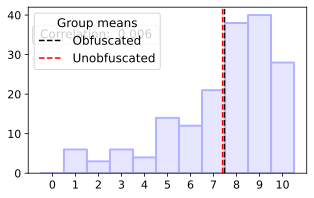

In [16]:
##########################################################################################
###### Self-reported difficulty histogram
##########################################################################################

plt.figure(figsize=(5, 3))
df['Q282_1'] = df['Q282_1'].astype(int, errors='ignore')
plt.hist(df['Q282_1'], bins=np.arange(-0.5, 11.5, 1), edgecolor=(0.7,0.7,1, 1), facecolor=(0, 0, 1, 0.1), lw=2)

# Add means
unobfuscated_m = df[df['obfuscate']==False]['Q282_1'].astype(int).mean()
obfuscated_m = df[df['obfuscate']==True]['Q282_1'].astype(int).mean()
linestyle_='--'
plt.axvline(obfuscated_m, linestyle=linestyle_, c='black', label='Obfuscated')
plt.axvline(unobfuscated_m, linestyle=linestyle_, c='red', label='Unobfuscated')

# Set x-axis ticks to be at integers 1 through 10
plt.xticks(range(0, 11), fontsize = '11')
plt.yticks(fontsize = '11')

# correlations
corr_all = np.corrcoef(df['score'], df['Q282_1'].astype(int))[0,1]

# make a box for the correlations
bbox_props = {
    'boxstyle': 'round',       
    'facecolor': 'white',      
    'edgecolor': 'lightgrey',  
    'linewidth': 1           
}

plt.text(
    -0.7, 35,                
    f' Correlation:  {corr_all:0.3f} ',     
    fontsize=12,                  
    ha='left',                    
    va='center',                  
    bbox=bbox_props            
)

# print and save
plt.legend(fontsize = '12', title='Group means', title_fontsize='12')
plt.savefig('../figs/self_reported_difficulty.pdf',bbox_inches='tight')
plt.show()

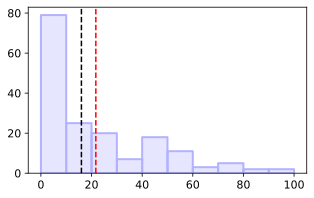

In [17]:
##########################################################################################
###### Scores histogram
##########################################################################################

plt.figure(figsize=(5, 3))
plt.hist(df['score'], bins=10, edgecolor=(0.7, 0.7, 1.0, 1.0), facecolor=(0, 0, 1, 0.1), lw=2)

# Add means
unobfuscated_m = df[df['obfuscate']==False]['score'].mean()
obfuscated_m = df[df['obfuscate']==True]['score'].mean()
linestyle_='--'
plt.axvline(obfuscated_m, linestyle=linestyle_, c='black', label='Obfuscated')
plt.axvline(unobfuscated_m, linestyle=linestyle_, c='red', label='Unobfuscated')

plt.xticks(fontsize = '11')
plt.yticks(fontsize = '11')

# save and show
plt.savefig('../figs/scores.pdf',bbox_inches='tight')
plt.show()

In [18]:
##########################################################################################
###### Means and counts
##########################################################################################

print(df.groupby('obfuscate')['score'].count())
print(f"Mean score: {df['score'].mean():0.2f}")                   
display(df.groupby('obfuscate')['score'].mean())

# breakthrough or foundational
breakthrough = ['Kabyle', 'Umbrian', 'Warlpiri']
df['breakthrough'] = df['language_name'].apply(lambda x: 1 if x in breakthrough else 0)

# Report breakdown by obfuscation type
display(df.groupby(['language_name', 'obfuscate'])['score'].mean())

# counts per problem and problem type
df.groupby(['language_name', 'obfuscate'])['score'].count()

obfuscate
False    86
True     86
Name: score, dtype: int64
Mean score: 18.85


obfuscate
False    21.699889
True     16.004983
Name: score, dtype: float64

language_name  obfuscate
Amele          False        15.000000
               True          3.333333
Kabyle         False        27.692308
               True         12.000000
Ligurian       False        22.857143
               True         24.761905
Tariana        False         7.142857
               True          0.000000
Umbrian        False        18.666667
               True         11.538462
Warlpiri       False        39.880952
               True         44.642857
Name: score, dtype: float64

language_name  obfuscate
Amele          False        15
               True         15
Kabyle         False        13
               True         15
Ligurian       False        15
               True         15
Tariana        False        14
               True         14
Umbrian        False        15
               True         13
Warlpiri       False        14
               True         14
Name: score, dtype: int64

In [19]:
# Mean scores above random by problem type
print(df[(df['above_rand']==1) & (df['obfuscate']==0)]['score'].mean())
print(df[(df['above_rand']==1) & (df['obfuscate']==1)]['score'].mean())

df[df['above_rand']==1].groupby(['obfuscate'])['score'].mean()

37.162293488824105
35.14157014157014


obfuscate
False    37.162293
True     35.141570
Name: score, dtype: float64

#### Data anlaysis

In [20]:
##########################################################################################
###### nonparametric tests - Mann Whitney U Test
##########################################################################################

x = df[df['obfuscate']==0]['score']
y = df[df['obfuscate']==1]['score']

U1, p = scipy.stats.mannwhitneyu(x, y, alternative='greater')
print(f'p-value: {p:0.4f}')

##########################################################################################
###### Mann Whitney U Test for self-reported difficulty
##########################################################################################

x = df[df['obfuscate']==0]['Q282_1']
y = df[df['obfuscate']==1]['Q282_1']

# Mann Whitney U test (p-value is 0.065) or one sided is 0.032
U1, p = scipy.stats.mannwhitneyu(x, y, alternative='greater')
print(f'p-value: {p:0.4f}')

p-value: 0.0412
p-value: 0.7196


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     14.13
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           5.97e-13
Time:                        16:34:11   Log-Likelihood:                -755.84
No. Observations:                 172   AIC:                             1526.
Df Residuals:                     165   BIC:                             1548.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

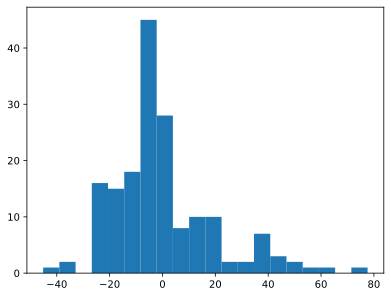

In [21]:
##########################################################################################
###### Linear regression - All data - Model 1
##########################################################################################

model = smf.ols('score ~ obfuscate + C(language_name)', data=df).fit(cov_type='HC1')
print(model.summary())

# check residuals plot
residuals = model.resid
plt.hist(residuals, bins=20)

# write to stargazer
model1_stargazer = smf.ols('score ~ obfuscate + C(language_name)', data=df).fit(cov_type='HC1')

########################################################################################
# Bootstrapped main regression to get the CI
########################################################################################

B = 10000

# note the model se doesn't really matter here as calculating new CI through iterations
model = smf.ols('score ~ obfuscate + language_name', data=df).fit()
param_names = model.params.index
n_params = len(param_names)
boot_params = np.zeros((B, n_params))

for b in range(B):
    sample_df = df.sample(n=len(df), replace=True)
    m_b = smf.ols('score ~ obfuscate + language_name', data=sample_df).fit()
    boot_params[b, :] = m_b.params[param_names]

boot_means = np.mean(boot_params, axis=0)
boot_se = np.std(boot_params, axis=0, ddof=1)

lower_bounds = np.percentile(boot_params, 2.5, axis=0)
upper_bounds = np.percentile(boot_params, 97.5, axis=0)


print("Bootstrapped Results\n" + "-"*30)
for i, pname in enumerate(param_names):
    print(f"Parameter: {pname}")
    print(f"  Original OLS Estimate    = {model.params[pname]:.3f}")
    print(f"  Boot Mean Estimate       = {boot_means[i]:.3f}")
    print(f"  95% CI (Percentile)      = [{lower_bounds[i]:.3f}, {upper_bounds[i]:.3f}]")

In [22]:
##########################################################################################
###### Linear regression - Model 2
###### Robust data (suspected cheating, nulls and low chrF removed)
##########################################################################################

model2_stargazer = smf.ols('score ~ obfuscate + C(language_name)', data=df_robust).fit(cov_type='HC1')
print(model2_stargazer.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     16.93
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           1.30e-14
Time:                        16:34:29   Log-Likelihood:                -642.76
No. Observations:                 146   AIC:                             1300.
Df Residuals:                     139   BIC:                             1320.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [23]:
##########################################################################################
###### Linear regression - Only those above random - Model 3
##########################################################################################

model3_stargazer = smf.ols('score ~ obfuscate + C(language_name)', data=df_above_random).fit(cov_type='HC1')
print(model3_stargazer.summary())

# render latex for all three models
stargazer = Stargazer([model1_stargazer, model2_stargazer, model3_stargazer])

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     7.239
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           3.53e-06
Time:                        16:34:29   Log-Likelihood:                -371.68
No. Observations:                  86   AIC:                             757.4
Df Residuals:                      79   BIC:                             774.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [24]:
##########################################################################################
###### Logistic regression
##########################################################################################

model_log = smf.logit('above_rand ~ obfuscate + language_name', data=df).fit(cov_type='HC1')
print(model_log.summary())

# write to latex
stargazer = Stargazer([model_log])

Optimization terminated successfully.
         Current function value: 0.580046
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             above_rand   No. Observations:                  172
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1632
Time:                        16:34:29   Log-Likelihood:                -99.768
converged:                       True   LL-Null:                       -119.22
Covariance Type:                  HC1   LLR p-value:                 7.465e-07
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0681      0.401      0.170      0.865      -0.